## setup and notebook configuration

In [1]:
import numpy as np
import time
import orthopy
from IPython.core.debugger import set_trace

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns
import cmocean as cmo
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#import src.fem_base.master.mk_master as mkm
import src.plot.matplotlib_utils as mplu
import src.fem_base.master.barycentric_coord_tools as bct
#from src.fem_base.master.polynomials_1D import Jacobi_Poly, Jacobi_Poly_Derivative
#import src.fem_base.master.nodal_basis_1D as NB1D
import src.fem_base.master.polynomials_1D as p1d
#import src.fem_base.master.polynomials_2D as p2d

# exposition

Initially it was intended that this material (robustly generating orthonormal polynomials over the reference triangle and quadrilateral) be glossed over in the construction of the 2D nodal bases. It turns out that this process is sufficiently complex and error-prone that it warrants its own tutorial.

## barycentric coordinate tools

In order to position points on the triangle, it will be convenient to work in [Barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system).
The following define the transformation to and from barycentric coordinates from cartesian coords.

In [5]:
# %load -s cart2bary,bary2cart ../src/fem_base/master/barycentric_coord_tools.py
def cart2bary(verts, pts):
    """ retrns barycentric coords of pt on a tri w/ vertices verts
    @param verts  tuple of tuples specifying verts
    @param pt  numpy array of point on triangle shape (2, npts)
    """
    npts = pts.shape[1]
    _lambda = np.zeros((3, npts))
    (x1, y1), (x2, y2), (x3, y3) = verts
    T = np.array([[x1 - x3, x2 - x3],
                  [y1 - y3, y2 - y3]])
    r = np.copy(pts)
    r[0,:] -= x3
    r[1,:] -= y3

    _lambda[:2, :] = np.linalg.solve(T, r)
    _lambda[2, :] = 1 - _lambda[0,:] - _lambda[1,:]
    return _lambda

def bary2cart(verts, _lambda):
    """converts from barycentric to cartesian coordinates
    @param verts  tuple of tuples specifying triangle vertices
    @param _lambda array of barycentric points (3, npts)
    """
    npts = _lambda.shape[1]
    λ1, λ2, λ3 = _lambda[0,:], _lambda[1,:], _lambda[2,:]
    x, y = np.zeros(npts), np.zeros(npts)
    (x1, y1), (x2, y2), (x3, y3) = verts
    x = λ1*x1 + λ2*x2 + λ3*x3
    y = λ1*y1 + λ2*y2 + λ3*y3
    return x, y


The following generates the barycentric coordinates corresponding to uniform nodes on a triangle for a polynomial order $p$.

In [6]:
# %load -s uniform_bary_coords ../src/fem_base/master/barycentric_coord_tools.py
def uniform_bary_coords(p):
    """ generate bary coords of uniform nodal pts for tri of order p"""
    N, Np = p, int((p+1)*(p+2)/2)
    node = 0
    bary = np.zeros((3, Np))
    for i in range(N+1):
        for j in range(N+1-i):
            λ1, λ2 = i/N, j/N
            λ3 = 1 - λ1 - λ2
            bary[:, node] = np.asarray([λ1, λ2, λ3])
            node += 1
    return bary


# orthonormal polynomials over the triangle

We need a way to generalize the 1D orthonormal polynomial basis to that over the standard simplex

$$T \equiv \{\mathbf{r}=(\xi, \eta) \mid (\xi, \eta) \leq -1; \xi+\eta \leq0\}$$

such that we can efficiently compute $\psi_m(\mathbf{r})$ over $T$. In Hesthaven and Warburton, the suggestion is to use the basis defined by

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

Where $P_n^{(\alpha, \beta)}$(x) is the familiar $n^{th}$ order Jacobi polynomial over [-1, 1] discussed in depth in the `1D_basis_and_master` tutorial. 

In [7]:
# serves as a view mesh for the shape functions we are about to create
p = 24
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
x, y = bary2cart(verts, bary)

### generating the underlying polynomial modal basis

In [8]:
# %load -s mk_m2ij,ortho_triangle ../src/fem_base/master/polynomials_2D.py
def mk_m2ij(p):
    """ returns a list A for which A[m] = (i,j) for orthopy polynomials psi_m"""
    return [(j,i) for i in range(p) for j in range(i+1)]

def ortho_triangle(bary, p):
    """ wraps orthopy, returns tree of orthonormal polys over bary coords
    @param bary  barycentric points on a triangle at which to eval polynomials
    @param p  the order of the basis -- how many polynomials we want
    @retval polys (npts, m) array of psi_m at the npts

    orthopy returns a list of arrays, where `out[k]` hosts the `2*k+1`
    values of the `k`th level of the tree
        (0, 0)
        (0, 1)   (1, 1)
        (0, 2)   (1, 2)   (2, 2)
          ...      ...      ...   (i, j)
    so we unpack the (i,j) into the index m via m2ij above.
    """
    m2ij = mk_m2ij(p)
    ortho_output = orthopy.triangle.tree(bary, n=p, standardization='normal')
    npts, npolys = bary.shape[1], len(m2ij)
    polys = np.zeros((npts, npolys))
    for m, (i,j) in enumerate(m2ij):
        polys[:,m] = ortho_output[j][i,:]
    return polys


In [9]:
# %load -s P_tilde ../src/fem_base/master/polynomials_2D.py
def P_tilde(pts, p, verts=((-1, -1), (1, -1), (-1, 1))):
    """ generates the values of the orthonormal modal polynomials at pts r on the reference tri
    @param verts  tuple of tuples specifying the CCW vertices of the triangle in question
    @param pts  points defined on the triangle defd by verts (npts, 2)
    @param p  order of the orthonormal polynomial basis to be generated
    """
    bary_coords = bct.cart2bary(verts, pts.T)
    polys = ortho_triangle(bary_coords, p+1)
    return polys


In [10]:
xy = np.vstack((x, y)).T
xy.shape
pp = P_tilde(xy, p)
print(p)
pp.shape, x.shape

24


((325, 325), (325,))

need a good way of drawing the polys and the shape functions over the reference triangle

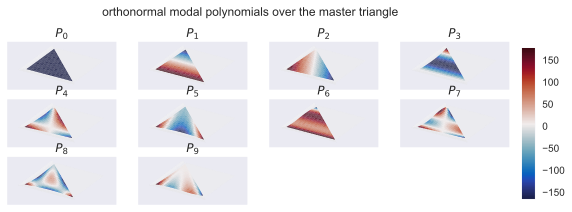

In [11]:
fig = plt.figure(figsize=(9, 3))
tri = mtri.Triangulation(x, y)
for i in range(10):
    ax = fig.add_subplot(3, 4, i+1, projection='3d')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, pp[:,i], cmap=cmo.cm.balance)
    ax.set_title(r'$P_{}$'.format(i), y=1.06)
    ax.view_init(elev=90)
mplu.add_shared_colorbar(fig, pp, cmap=cmo.cm.balance)
fig.suptitle('orthonormal modal polynomials over the master triangle', y=1.04)
plt.show()

If we expect the correct behavior, the hesthaven functions have to be called correctly below.

In [12]:
# %load -s xi_eta_to_ab ../src/fem_base/master/polynomials_2D.py
def xi_eta_to_ab(ξ, η):
    """ function to transform xi, eta coords to a, b
    see Hesthaven function 'rstoab'
    @param xi, eta vectors of xi, eta pts
    """
    a, b = np.zeros_like(ξ), np.zeros_like(η)
    singular = np.isclose(η, 1.0)
    nonsingular = np.logical_not(singular)
    a[nonsingular] = 2*(1. + ξ[nonsingular])/(1 - η[nonsingular]) - 1
    a[singular] = -1
    b = η
    return a, b


In [13]:
def Simplex2D(a, b, i, j):
    """ copied from hesthaven """
    h1 = p1d.JacobiP(a, 0, 0, i)
    h2 = p1d.JacobiP(b, 2*i+1, 0, j)
    P = np.sqrt(2.)*h1*h2*(1-b)**i
    return P

In [14]:
def VanH2D(N, ξ, η):
    a, b = xi_eta_to_ab(ξ, η)
    Np = int((N+1)*(N+2)/2)
    V2d = np.zeros((len(ξ), Np))
    counter = 0
    for i in range(N+1):
        for j in range(N-i+1):
            m = j + (N+1)*i + 1 - i/2.*(i-1)
            V2d[:,counter] = Simplex2D(a, b, i,j)
            counter += 1
    return V2d

(325, 10)


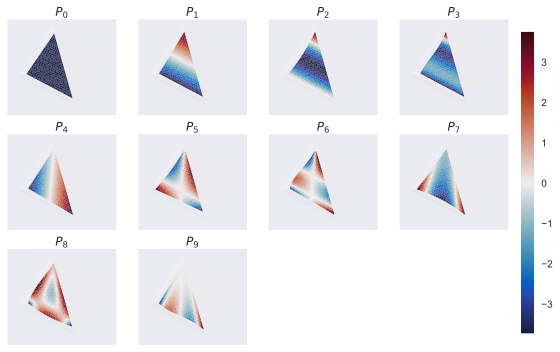

In [15]:
V2d = VanH2D(3, x, y)

print(V2d.shape)

fig = plt.figure(figsize=(9,6))
tri = mtri.Triangulation(x, y)

# data limits

for gg in range(10):
    ps2d = V2d[:, gg]
    ax = fig.add_subplot(3, 4, gg+1, projection='3d')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, V2d[:,gg], cmap=cmo.cm.balance)
    ax.set_title(r'$P_{}$'.format(gg), y=1.06)
    ax.view_init(elev=90)
mplu.add_shared_colorbar(fig, ps2d, cmap=cmo.cm.balance)
plt.show()


Really dig in here. 

Need to write convenience functions which actually return order i, j etc.
Need to check for orthonormality in unit test

### shape function derivatives

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

So naturally
<img src="img/master_tri_func_dependence.png" alt="drawing" style="width: 250px;"/>
and the chain rule suggests that

\begin{align}
  \frac{d\psi_m}{d\xi} &= \frac{\partial a}{\partial\xi}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - \eta}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - b} \cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}\left( P_i(a)  \right) \\
    &= 2(1-b)^{i-1}\cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\,\frac{\partial}{\partial a}\left( P_i(a)  \right)
  \end{align}
  
  
  \begin{align}
  \frac{d\psi_m}{d\eta} &= \frac{\partial a}{\partial \eta}\frac{\partial \psi_m}{\partial a} + \frac{db}{d\eta}\frac{d\psi_m}{db}
  = \frac{2(1+\xi)}{(1-\eta)^2}\frac{\partial \psi_m}{\partial a} + \frac{d\psi_m}{db} \\
  &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\frac{\partial}{db}\left((1-b)^i\,P_j^{(2i+1, 0)}(b)\right) \\
%    &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\left[(1-b)^i\,\frac{\partial}{db}\left(P_j^{(2i+1, 0)}(b)\right) + P_j^{(2i+1, 0)}(b)\left(i(1-b)^{i-1}\right)\right] \\
\end{align}

We follow Hesthaven's simplified and normalized expression which is equivalent to the above.

In [16]:
# %load -s poly_gradient_simplex,GradVandermonde2D ../src/fem_base/master/polynomials_2D.py
def poly_gradient_simplex(a, b, i, j):
    """ takes derivatives of modal basis polys w/r/t ξ, η
    transcribed from GradSimplex2D in Hesthaven
    """
    Pa, dP_da = p1d.JacobiP(a,0,    0,i), p1d.GradJacobiP(a,0    ,0,i)
    Pb, dP_db = p1d.JacobiP(b,2*i+1,0,j), p1d.GradJacobiP(b,2*i+1,0,j)

    # d/dξ = da/dξ * d/da + db/dξ * d/db = 2/(1-b) d/da
    dψ_dξ = dP_da * Pb
    if i > 0:
        dψ_dξ *= ( (0.5*(1-b))**(i-1) )

    # d/dη = ((1+a)/2)/((1-b)/2)d/da + d/db
    dψ_dη = dP_da * (Pb * 0.5*(1+a))
    if i > 0:
        dψ_dη *= ((0.5*(1-b))**(i-1))

    tmp = dP_db * (0.5*(1-b))**(i)
    if i > 0:
        tmp -= 0.5*i*Pb * (0.5*(1-b))**(i-1)
    dψ_dη += Pa * tmp

    # normalize both derivatives
    dψ_dξ *= 2**(i+0.5)
    dψ_dη *= 2**(i+0.5)
    return [dψ_dξ, dψ_dη]

def GradVandermonde2D(p, ξ, η):
    """ compute the derivative vandermonde matrices in ξ, η directions """
    Np = int((p+1)*(p+2)/2)
    npts = len(ξ)
    a, b = xi_eta_to_ab(ξ, η)
    dVξ, dVη = np.zeros((npts, Np)), np.zeros((npts, Np))
    counter = 0
    for i in range(p+1):
        for j in range(p-i+1):
            dψ_dξ, dψ_dη = poly_gradient_simplex(a, b, i, j)
            dVξ[:,counter] = dψ_dξ
            dVη[:,counter] = dψ_dη
            counter += 1
    return [dVξ, dVη]


In [17]:
# indices
p=2
gv = GradVandermonde2D(p, x, y)
V2d = VanH2D(p, x, y)

Plot the polynomials, along with the derivative in each coordinate direction.

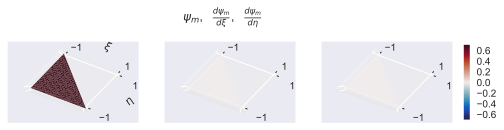

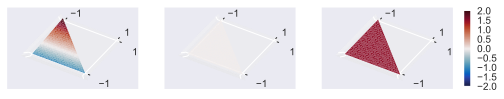

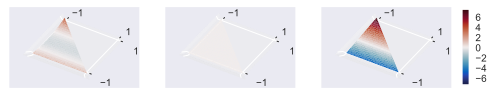

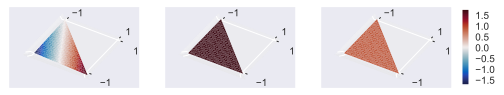

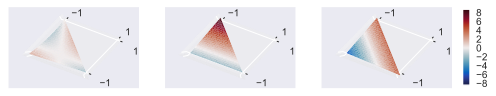

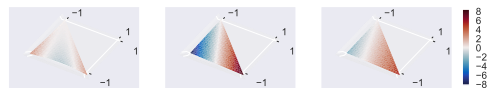

In [18]:
tri = mtri.Triangulation(x, y)
nbasis_functions = V2d.shape[1]
grid=(1,3)

for m in range(nbasis_functions):
    
    fig = plt.figure(figsize=(8, 1.5))
    counter = 1
    data = np.vstack((V2d[:,m], gv[0][:,m], gv[1][:,m]))
    dmax = np.max(np.abs(data))
    #vmax, vmin = np.max(data), np.min(data)
    vmax, vmin = dmax, -1*dmax
    
    # original polynomial
    ax = fig.add_subplot(*grid, counter, projection='3d')
    if m==0:
        ax.set_xlabel(r'$\xi$')
        ax.set_ylabel(r'$\eta$')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, V2d[:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    # derivative in ξ direction
    ax = fig.add_subplot(*grid, counter, projection='3d')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, gv[0][:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    # derivative in η direction
    ax = fig.add_subplot(*grid, counter, projection='3d')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, gv[1][:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    mplu.add_shared_colorbar(fig, np.linspace(vmin, vmax, 100), cmap=cmo.cm.balance,
                             cbar_ax=[0.92, 0.15, 0.01, 0.7])
    if m == 0:
        fig.suptitle(r'$\psi_m$,   $\frac{d\psi_m}{d\xi}$,   $\frac{d\psi_m}{d\eta}$',
                     y=1.2)
    plt.show()

Check that the magnitudes of the constant derivatives are correct

In [19]:
# zero derivatives are zero
should_be_null = [gv[0][:,0], gv[1][:,0], gv[0][:,1], gv[0][:,2]]
assert np.all([np.allclose(arr, 0.) for arr in should_be_null])

# m = 1: dψ/dη constant is correcct
ψ1 = V2d[:,1]
slope = (np.max(ψ1) - np.min(ψ1))/2.
assert np.isclose(gv[1][:,1][0], slope)

# m = 3: dψ/dξ constant is correct
ψ3 = V2d[:,3]
slope = (np.max(ψ3) - np.min(ψ3))/2.
assert np.isclose(gv[0][:,3][0], slope)

# TODO

- unit test where we transform from bary 2 cart 2 bary again
- unit test where we integrate the polys and recover the identity matrix
- unit test where we check Lesbesgue constant and compare to Hesthaven's
- hit polynomial functions with Dr to see if they converge to check derivatives
- should these orthonormal basis over a simplex be made a class? is it complex enough for that?